# **Inference with existing model**


In [1]:
from google.colab import drive
drive.mount('/content/gdirve')

Mounted at /content/gdirve


In [2]:
%ls

gdirve/  sample_data/


In [3]:
%cd /content/gdirve/MyDrive/faults_pr3/

/content/gdirve/MyDrive/faults_pr3


In [4]:
%cd dataset/

/content/gdirve/MyDrive/faults_pr3/dataset


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[ 0.00823975  0.0109863   0.00839233 ... -0.0149536   0.0267029
  0.0189209 ]


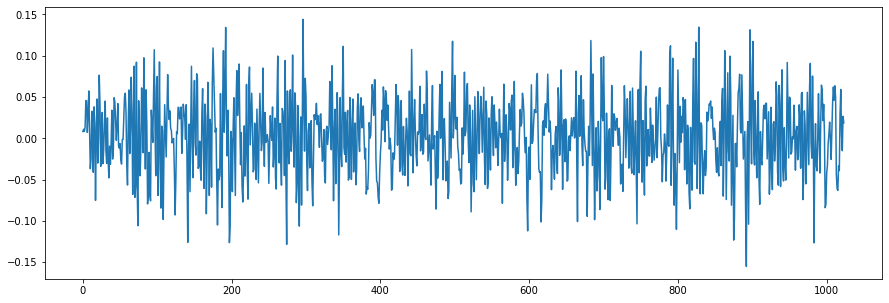

Correct
The fault is SC8T


In [5]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.relu=nn.ReLU()
        self.dropout = nn.Dropout(0.5) 
        self.conv1=nn.Conv1d(in_channels=1, out_channels=64, kernel_size=(50))
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=(1,3))

        self.conv2=nn.Conv1d(in_channels=64, out_channels=64, kernel_size=(30))
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(1,3))

        self.conv3=nn.Conv1d(in_channels=64, out_channels=64, kernel_size=(30))
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=(1,3))

        self.conv4=nn.Conv1d(in_channels=64, out_channels=64, kernel_size=(23))
        self.bn4 = nn.BatchNorm1d(64)
        self.pool4 = nn.MaxPool2d(kernel_size=(1,3))

        # self.lstm1 = nn.LSTM(input_size=64, hidden_size=128, num_layers=2)
        self.fc3=nn.Linear(in_features=64, out_features=64)
        self.fc=nn.Linear(in_features=64, out_features=4)
    
    def forward(self, x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.pool1(x)

        x=self.conv2(x)
        x=self.relu(x)
        x=self.pool2(x)

        x=self.conv3(x)
        x=self.relu(x)
        x=self.pool3(x)

        x=self.conv4(x)
        x=self.relu(x)
       
        x = x.view(-1,64)
        # x,_ = self.lstm1(x)
        # x = x.contiguous().view(-1, 128)
        # x = self.dropout(x)
        # x=x[-1]
        
        x=self.fc3(x)
        x=self.fc(x)
        x = x.view(1, -1, 4)[:,-1,:]
        return x

def init_detector(checkpoint= None, device = 'cuda:0'):
  model = CNN()
  if checkpoint is not None:
    map_loc = 'cpu' if device == 'cpu' else None
    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['state_dict'])
  return model

def inference_detector(model, data):
  device = next(model.parameters()).device
  with torch.no_grad():
    results = model(data)
  return results

def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    # assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        # yield inputs[excerpt], targets[excerpt]
        yield inputs, targets

def main():
  checkpoint = '/content/gdirve/MyDrive/faults_pr3/models/CNN/stator_faults_49.pth'
  model = init_detector(checkpoint)
  
  input = np.load('X.npy')
  labels = np.load('Y.npy')

  input = input.reshape(3999, 1024, 1)
  labels = labels.reshape(3999)

  suffer_idx = np.random.permutation(labels.shape[0])

  input = input[suffer_idx]
  labels = labels[suffer_idx]

  test_x = input[0:int(labels.shape[0]*0.7)]
  test_x = np.transpose(test_x, axes= [0,2,1])
  test_x = torch.from_numpy(test_x).float()
  test_y = labels[0:int(labels.shape[0]*0.7)]
  test_y = torch.from_numpy(test_y).long()

  infer_x = test_x[0]
  infer_x = infer_x.reshape(1, 1, 1024)
  gt = test_y[0]
  gt = gt.reshape(1,)

  for batch_x, batch_y in iterate_minibatches(infer_x, gt, batchsize=1):
    infer_x = batch_x
    gt = batch_y

  if torch.cuda.is_available:
    model = model.cuda()
    infer_x = infer_x.cuda()
    gt = gt.cuda()
    
  predict_y = inference_detector(model, infer_x)
  _, predict = torch.max(predict_y, 1)

  infer_x = infer_x.reshape(1024)
  infer_x = infer_x.cpu().detach().numpy()
  print(infer_x)
  plt.figure(figsize=(15, 5))
  plt.plot(infer_x)
  plt.show()

  if predict == gt:
    print('Correct')
    if predict == 0:
      print('Normal')
    if predict == 1:
      print('The fault is SC2T')
    if predict == 2:
      print('The fault is SC4T')
    if predict == 3:
      print('The fault is SC8T')
  else:
    print('Incorrect')
main()

In [ ]:
%ls


cnn.ipynb       f1.npy    models/           test_acc.npy        valid_loss.npy
cnn_lstm.ipynb  feature/  precision.npy     train_accuracy.npy
data.ipynb      lib/      preprocess.ipynb  train_loss.npy
dataset/        lstm/     recall.npy        valid_accuracy.npy
